In [1]:
import pandas as pd

time_series_data = pd.read_csv("output.csv")

In [2]:
time_series_data['updated'] = pd.to_datetime(time_series_data['updated'])

In [3]:
time_series_data.sort_values('updated')

timestamp_scrape  percentage  \
0       2023-08-21 12:46:19.447804-04:00   50.000000   
1       2023-08-01 14:06:39.305577-04:00   66.666667   
2       2023-08-01 14:25:08.031912-04:00   66.666667   
3       2023-08-01 14:31:15.129721-04:00   66.666667   
4       2023-07-20 15:02:23.921792-04:00   66.666667   
...                                  ...         ...   
169165  2024-09-09 11:39:25.970328-04:00   50.000000   
169167  2024-09-09 11:39:25.970657-04:00   18.181818   
169168  2024-09-09 11:39:25.970807-04:00   12.121212   
169169  2024-09-09 11:39:25.970947-04:00   43.809524   
169170  2024-09-09 11:39:25.971085-04:00   10.000000   

                    location_name  last_count             updated  \
0       Marino Center - Gymnasium          30 2023-05-06 18:36:00   
1       SquashBusters - 4th Floor          40 2023-06-08 17:50:00   
2       SquashBusters - 4th Floor          40 2023-06-08 17:50:00   
3       SquashBusters - 4th Floor          40 2023-06-08 17:50:00   
4       SquashBusters - 4th Floor          40 2023-06-08 17:50:00   
...                           ...         ...                 ...   
169165  SquashBusters - 4th Floor          30 2024-09-09 11:33:00   
169167   Marino Center - Studio A           6 2024-09-09 11:33:00   
169168   Marino Center - Studio B           4 2024-09-09 11:33:00   
169169  Marino Center - 2nd Floor          46 2024-09-09 11:33:00   
169170  Marino Center - Gymnasium           6 2024-09-09 11:33:00   

        open_boolean  
0               True  
1               True  
2               True  
3               True  
4               True  
...              ...  
169165          True  
169167          True  
169168          True  
169169          True  
169170          True  

[169173 rows x 6 columns]

In [4]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft

gym_data = time_series_data[time_series_data['location_name'] == 'Marino Center - 3rd Floor']
data = gym_data[['updated','last_count']]


In [5]:
len(gym_data['updated'])

0

['Marino Center - Gymnasium' 'SquashBusters - 4th Floor'
 'Marino Center - 3rd Floor Weight Room'
 'Marino Center - 3rd Floor Select & Cardio' 'Marino Center - 2nd Floor'
 'Functional Training Area' 'Studio B' 'Studio A' 'INV'
 'FTA @ SquashBusters' 'Marino Center - Studio A'
 'Marino Center - Studio B']


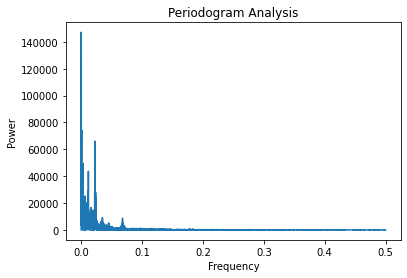

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram

# Read the CSV file
time_series_data = pd.read_csv("output.csv")

# Convert 'updated' column to datetime
time_series_data['updated'] = pd.to_datetime(time_series_data['updated'])

# Print unique locations
print(time_series_data['location_name'].unique())

# Filter the data for a specific gym location
gym_data = time_series_data[time_series_data['location_name'] == 'Marino Center - 3rd Floor Weight Room']

# Select relevant columns
data = gym_data[['updated', 'last_count']]

# Sort values based on 'updated'
data = data.sort_values('updated')

# Set 'updated' as the index
data.set_index('updated', inplace=True)

# Filter out rows where 'last_count' is 0
data_non_zero = data[data['last_count'] > 0]

# Perform periodogram analysis
f, Pxx = periodogram(data_non_zero['last_count'])

# Plot the results
plt.plot(f, Pxx)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Periodogram Analysis')
plt.show()

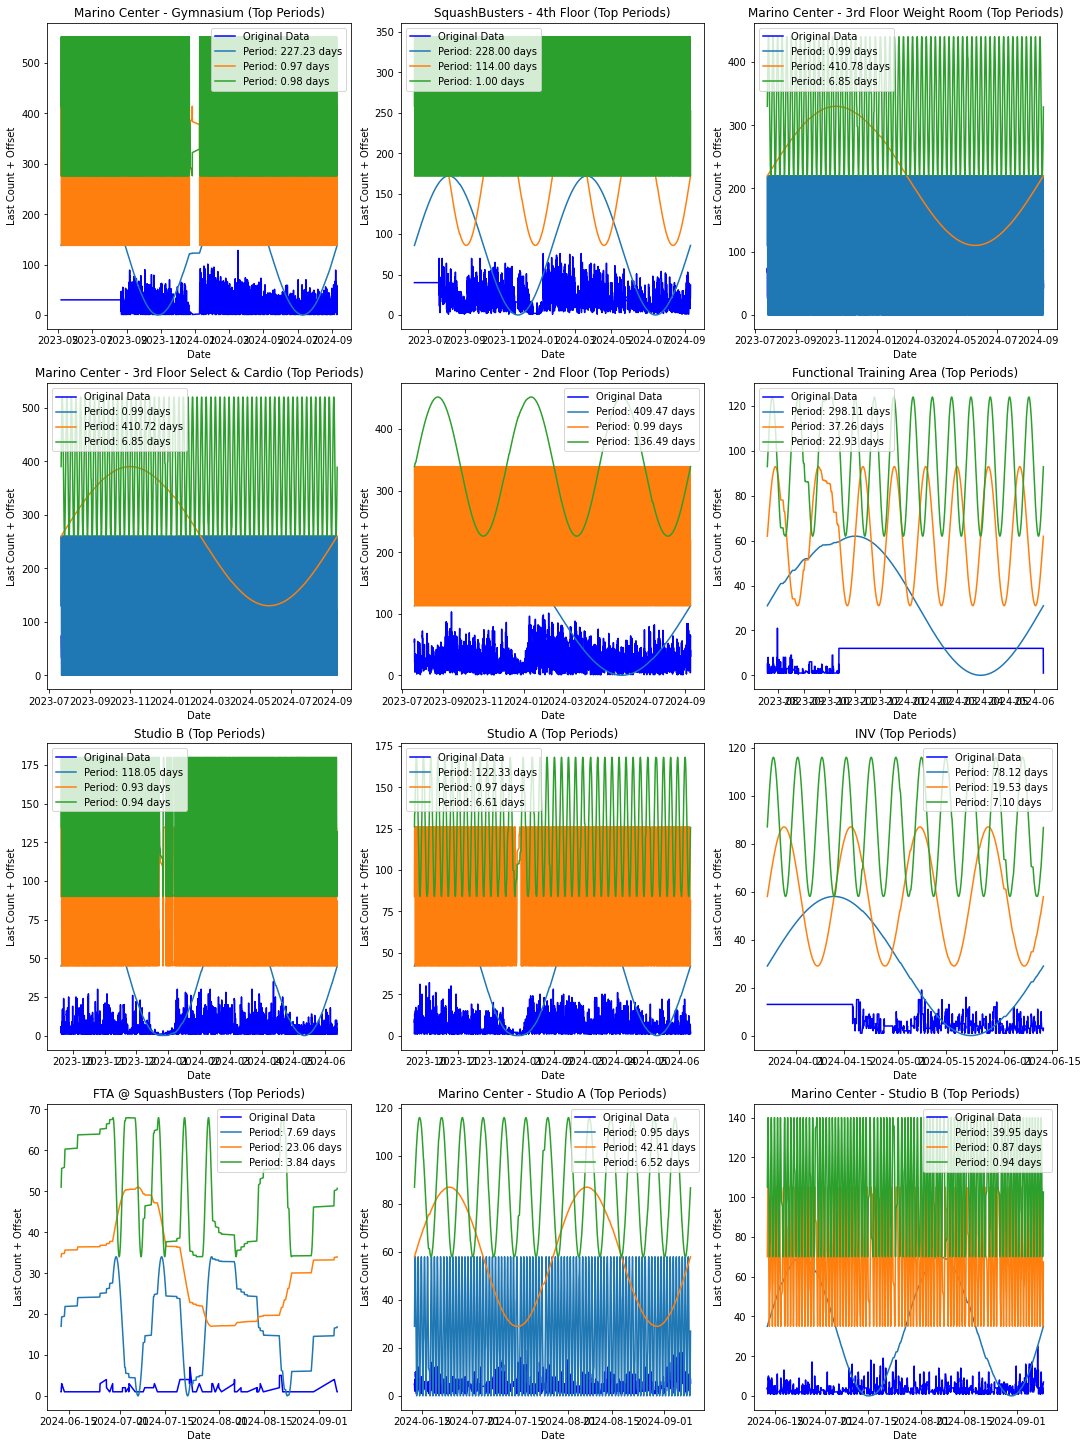

In [7]:
# Re-import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram, find_peaks

# Load the data from the newly uploaded file
time_series_data = pd.read_csv('output.csv')

# Convert the 'updated' column to datetime
time_series_data['updated'] = pd.to_datetime(time_series_data['updated'])

# Get the unique locations
unique_locations = time_series_data['location_name'].unique()

# Determine grid size for subplots based on number of locations
num_locations = len(unique_locations)
num_columns = 3  # Define the number of columns in the grid
num_rows = int(np.ceil(num_locations / num_columns))  # Calculate the required number of rows

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5), constrained_layout=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Define a function to perform periodogram analysis and plot for a given location
def plot_location_periodogram(location, ax):
    # Filter data for the given location
    location_data = time_series_data[time_series_data['location_name'] == location]
    
    # Process data for non-zero last counts
    data = location_data[['updated', 'last_count']].copy()
    data.sort_values('updated', inplace=True)
    data.set_index('updated', inplace=True)
    data = data.groupby(data.index).mean()
    data = data.resample('15T').ffill()
    data_non_zero = data[data['last_count'] > 0]
    
    # Calculate the periodogram for non-zero last count data
    frequencies, Pxx = periodogram(data_non_zero['last_count'])
    
    # Find peaks in the periodogram data to determine the significant frequencies
    peaks_indices = find_peaks(Pxx)[0]
    peak_frequencies = frequencies[peaks_indices]
    peak_powers = Pxx[peaks_indices]
    
    # Sort the peaks by power and select the top 3
    sorted_indices = np.argsort(peak_powers)[::-1][:3]
    top_frequencies = peak_frequencies[sorted_indices]
    top_periods_samples = 1 / top_frequencies  # periods in number of samples
    
    # Since each sample represents 15 minutes, convert periods to days
    top_periods_days = top_periods_samples * (15 / (60 * 24))  # Convert from samples to days
    
    # Create sine waves for each of the top periods
    time_vector = np.arange(data_non_zero.shape[0]) * (15 / (60 * 24))  # Convert index to days
    offset = data_non_zero['last_count'].max() + 10
    
    # Plot original data
    ax.plot(data_non_zero.index, data_non_zero['last_count'], color='blue', label='Original Data')
    
    # Plot sine waves for the top periods
    for i, period in enumerate(top_periods_days):
        sine_wave = np.sin(2 * np.pi * time_vector / period) * offset + (i + 1) * offset
        ax.plot(data_non_zero.index, sine_wave, label=f'Period: {period:.2f} days')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Last Count + Offset')
    ax.set_title(f'{location} (Top Periods)')
    ax.legend()


# Loop through each location and apply the periodogram analysis and plotting
for i, location in enumerate(unique_locations):
    plot_location_periodogram(location, axes[i])

# Hide any unused subplots
for j in range(i + 1, num_rows * num_columns):
    axes[j].axis('off')

# Show the figure
plt.show()


In [8]:
sine_wave

NameError: name 'sine_wave' is not defined

In [ ]:
data_non_zero.plot()

In [ ]:
plt.plot(f,Pxx)

In [9]:
data_resampled = data

In [10]:
gym_data.dtypes

timestamp_scrape            object
percentage                 float64
location_name               object
last_count                   int64
updated             datetime64[ns]
open_boolean                  bool
dtype: object

In [11]:
data = gym_data[['updated','last_count']]
data

updated  last_count
5      2023-06-28 15:57:00           0
6      2023-06-28 15:57:00           0
8      2023-06-28 15:57:00           0
13     2023-06-28 15:57:00           0
14     2023-06-28 15:57:00           0
...                    ...         ...
169139 2024-09-09 10:00:00          50
169142 2024-09-09 10:26:00          42
169155 2024-09-09 10:58:00          48
169163 2024-09-09 10:58:00          48
169171 2024-09-09 11:31:00          47

[23992 rows x 2 columns]

In [12]:
data.set_index('updated',inplace=True)

In [13]:
data

last_count
updated                        
2023-06-28 15:57:00           0
2023-06-28 15:57:00           0
2023-06-28 15:57:00           0
2023-06-28 15:57:00           0
2023-06-28 15:57:00           0
...                         ...
2024-09-09 10:00:00          50
2024-09-09 10:26:00          42
2024-09-09 10:58:00          48
2024-09-09 10:58:00          48
2024-09-09 11:31:00          47

[23992 rows x 1 columns]

<AxesSubplot:xlabel='updated'>

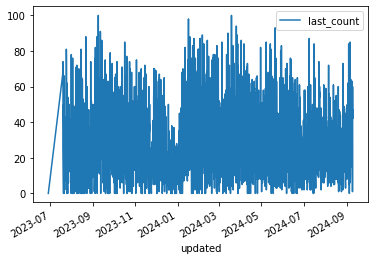

In [14]:
data.plot()

In [15]:
data.sort_values('updated',inplace=True)

/var/folders/hx/pb7z003d0wv2wjbzhd36msn40000gn/T/ipykernel_3797/2564204366.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values('updated',inplace=True)


In [16]:
data

last_count
updated                        
2023-06-28 15:57:00           0
2023-06-28 15:57:00           0
2023-06-28 15:57:00           0
2023-06-28 15:57:00           0
2023-06-28 15:57:00           0
...                         ...
2024-09-09 10:00:00          50
2024-09-09 10:26:00          42
2024-09-09 10:58:00          48
2024-09-09 10:58:00          48
2024-09-09 11:31:00          47

[23992 rows x 1 columns]

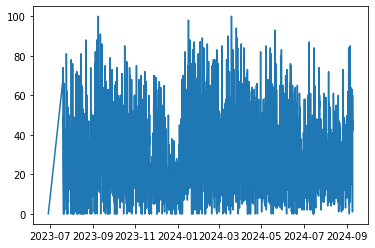

In [17]:
plt.plot(data.last_count)

In [18]:
f, Pxx = periodogram(data.last_count)

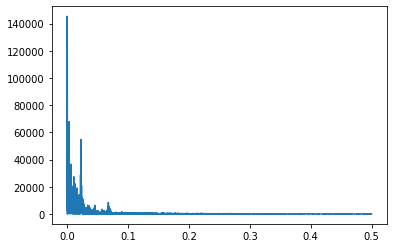

In [19]:
plt.plot(f, Pxx)
